# Wasserstein GAN

Introduction to **Wasserstein GAN** or WGAN.

This notebook is organized as follows:

1. **<a href="#background">Background</a>**

1. **<a href="#definition">Definition</a>**

1. **<a href="#training">Training WGAN with MNIST dataset, Keras and TensorFlow</a>**

---

<h2><a name="#background">1. Background</a></h2>

<h2><a name="#definition">2. Definition</a></h2>

<h2><a name="#training">3. Training WGANs with MNIST dataset,  Keras and TensorFlow</a></h2>


### 1. Load data

#### Load libraries

In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Input, Dense, ReLU, LeakyReLU, BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.optimizers import RMSprop
from keras import initializers
from keras import backend as K

Using TensorFlow backend.


#### Getting the data

In [3]:
# load dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#### Explore visual data

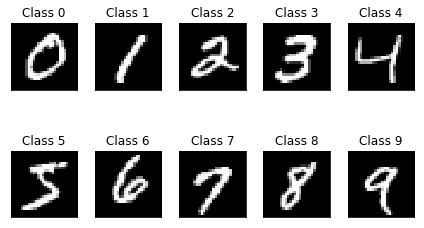

In [4]:
fig = plt.figure()
for i in range(10):
    plt.subplot(2, 5, i+1)
    x_y = X_train[y_train == i]
    plt.imshow(x_y[0], cmap='gray', interpolation='none')
    plt.title("Class %d" % (i))
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()

#### Reshaping and normalizing the inputs

In [5]:
print('X_train.shape', X_train.shape)

if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
    X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
    input_shape = (1, 28, 28)
else:
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
    X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
    input_shape = (28, 28, 1)

# the generator is using tanh activation, for which we need to preprocess 
# the image data into the range between -1 and 1.

X_train = np.float32(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)

print('X_train reshape:', X_train.shape)

X_train.shape (60000, 28, 28)
X_train reshape: (60000, 28, 28, 1)


In [6]:
print(X_train[0].shape)

(28, 28, 1)


### 2. Define model

#### Generator


In [7]:
# latent space dimension
latent_dim = 100

# imagem dimension 28x28x1
img_dim = 784

# Generator network
generator = Sequential()

# FC: 7x7x256
generator.add(Dense(7*7*256, input_shape=(latent_dim,)))
generator.add(Reshape((7, 7, 256)))
generator.add(ReLU())

# # Conv 1: 14x14x128
generator.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
generator.add(BatchNormalization(momentum=0.8))
generator.add(ReLU())

# Conv 2: 28x28x64
generator.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))
generator.add(BatchNormalization(momentum=0.8))
generator.add(ReLU())

# Conv 3: 28x28x32
generator.add(Conv2DTranspose(32, kernel_size=3, strides=1, padding='same'))
generator.add(BatchNormalization(momentum=0.8))
generator.add(ReLU())

# Conv 4: 28x28x1
generator.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same',
                              activation='tanh'))

#### Generator model visualization

In [8]:
# prints a summary representation of your model
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
re_lu_1 (ReLU)               (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 128)       295040    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
re_lu_2 (ReLU)               (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 64)        73792     
__________

#### Critic


In [9]:
# Critic network
critic = Sequential()

# imagem shape 28x28x1
img_shape = X_train[0].shape

# Conv 1: 14x14x64
critic.add(Conv2D(32, kernel_size=3, strides=2, padding='same',
                  input_shape=(img_shape)))
critic.add(LeakyReLU(0.2))

# Conv 2:
critic.add(Conv2D(64, kernel_size=3, strides=2, padding='same'))
critic.add(BatchNormalization(momentum=0.8))
critic.add(LeakyReLU(0.2))

# Conv 3: 
critic.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
critic.add(BatchNormalization(momentum=0.8))
critic.add(LeakyReLU(0.2))

# Conv 4: 
critic.add(Conv2D(512, kernel_size=3, strides=1, padding='same'))
critic.add(BatchNormalization(momentum=0.8))
critic.add(LeakyReLU(0.2))

# FC
critic.add(Flatten())

# Output
critic.add(Dense(1))

#### Critic model visualization

In [10]:
# prints a summary representation of your model
critic.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
batch_normalization_5 (Batch (None, 4, 4, 128)         512       
__________

### 3. Compile model

#### Compile discriminator

In [11]:
# Wasserstein objective
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

In [12]:
# Following parameter and optimizer set as recommended in paper
n_critic = 5
clip_value = 0.01
optimizer = RMSprop(lr=0.00005)

critic.compile(optimizer=optimizer, loss=wasserstein_loss, metrics=['accuracy'])

#### Combined network

We connect the generator and the critic to make a WGAN.

In [13]:
critic.trainable = False

# The generator takes noise as input and generated imgs
z = Input(shape=(latent_dim,))
img = generator(z)

# The critic takes generated images as input and determines validity
valid = critic(img)

# The combined model (critic and generative)
c_g = Model(inputs=z, outputs=valid, name='wgan')

c_g.compile(optimizer=optimizer, loss=wasserstein_loss, metrics=['accuracy'])

#### GAN model vizualization

In [14]:
# prints a summary representation of your model
c_g.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         1655425   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 694017    
Total params: 2,349,442
Trainable params: 1,654,977
Non-trainable params: 694,465
_________________________________________________________________


### 4. Fit model


epoch = 1/100, d_loss=-0.003, g_loss=0.023                                                                                                                       


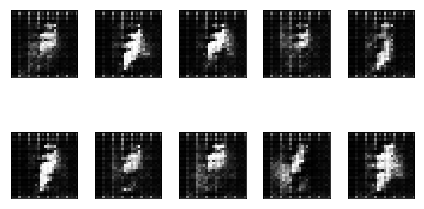

epoch = 2/100, d_loss=-0.000, g_loss=0.000                                                                                                                      
epoch = 3/100, d_loss=-0.001, g_loss=0.001                                                                                                                       
epoch = 4/100, d_loss=-0.001, g_loss=0.001                                                                                                                       
epoch = 5/100, d_loss=-0.001, g_loss=0.002                                                                                                                       
epoch = 6/100, d_loss=-0.000, g_loss=-0.000                                                                                                                      


KeyboardInterrupt: 

In [16]:
epochs = 100
batch_size = 64

real = -np.ones(shape=(batch_size, 1))
fake = np.ones(shape=(batch_size, 1))

d_loss = []
g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):
        for _ in range(n_critic):

            # Train Discriminator weights
            critic.trainable = True

            # Real samples
            X_batch = X_train[i*batch_size:(i+1)*batch_size]
            d_loss_real = critic.train_on_batch(X_batch, real)

            # Fake Samples
            z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
            X_fake = generator.predict(z)
            d_loss_fake = critic.train_on_batch(X_fake, fake)

            # Discriminator loss
            d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])

            # Clip critic weights
            for l in critic.layers:
                weights = l.get_weights()
                weights = [np.clip(w, -clip_value, clip_value) for w in weights]
                l.set_weights(weights)

        # Train Generator weights
        critic.trainable = False
        g_loss_batch = c_g.train_on_batch(z, real)

        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, g_loss_batch[0]),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch)
    g_loss.append(g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], g_loss[-1]), 100*' ')

    if e % 10 == 0:
        samples = 10
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, latent_dim)))

        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()

### 5. Evaluate model

In [ ]:
# plotting the metrics
plt.plot(d_loss)
plt.plot(g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()

## References

* [Wasserstein GAN](https://arxiv.org/pdf/1701.07875.pdf)
* [THE MNIST DATABASE of handwritten digits](http://yann.lecun.com/exdb/mnist/)